In [8]:
from e2cnn import gspaces                                          #  1
from e2cnn import nn as e2nn                                               #  2
import torch                                                       #  3
                                                                   #  4
r2_act = gspaces.Rot2dOnR2(N=4)                                    #  5
feat_type_in  = e2nn.FieldType(r2_act,  3*[r2_act.trivial_repr])     #  6
feat_type_out = e2nn.FieldType(r2_act, 10*[r2_act.regular_repr])     #  7
                                                                   #  8
conv = e2nn.R2Conv(feat_type_in, feat_type_out, kernel_size=5)       #  9
relu = e2nn.ReLU(feat_type_out)                                      # 10
                                                                   # 11
x = torch.randn(16, 3, 32, 32)                                     # 12
x = e2nn.GeometricTensor(x, feat_type_in)                            # 13
                                                                   # 14
y = relu(conv(x))                                                  

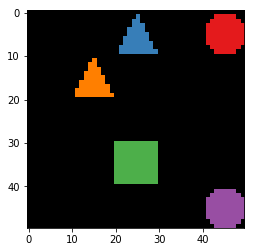

KeyboardInterrupt: Interrupted by user

In [9]:



import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from envs.block_pushing import BlockPushing
#from envs.block_pushing_cursor import BlockPushingCursor
import utils

#matplotlib.use("TkAgg")


def main():

    env = BlockPushing(render_type="shapes")
    env.reset()

    while True:

        img = env.render()
        plt.imshow(utils.css_to_ssc(img))
        plt.show()

        while True:
            x = input("action: ")
            try:
                x = int(x)
            except Exception:
                continue
            if x < 8:
                break

        env.step(x)


main()


In [10]:
from torch import nn

class EncoderCNNSmall(nn.Module):
    """CNN encoder, maps observation to obj-specific feature maps."""
    
    def __init__(self, input_dim, hidden_dim, num_objects, act_fn='sigmoid',
                 act_fn_hid='relu'):
        super(EncoderCNNSmall, self).__init__()
        self.cnn1 = nn.Conv2d(
            input_dim, hidden_dim, (10, 10), stride=10)
        self.cnn2 = nn.Conv2d(hidden_dim, num_objects, (1, 1), stride=1)
        self.ln1 = nn.BatchNorm2d(hidden_dim)
        self.act1 = utils.get_act_fn(act_fn_hid)
        self.act2 = utils.get_act_fn(act_fn)

    def forward(self, obs):
        h = self.act1(self.ln1(self.cnn1(obs)))
        return self.act2(self.cnn2(h))

In [26]:
r2_act = gspaces.Rot2dOnR2(N=4) 
 
feat_type_in = e2nn.FieldType(r2_act, 3*[r2_act.trivial_repr])
feat_type_hid = e2nn.FieldType(r2_act, (512//16)//4*[r2_act.regular_repr])
feat_type_out = e2nn.FieldType(r2_act, 1*[r2_act.trivial_repr])

EqEnc = e2nn.SequentialModule(
    e2nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=10,stride=10),
    e2nn.InnerBatchNorm(feat_type_hid),
    e2nn.ReLU(feat_type_hid),
    e2nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=1),
    e2nn.ReLU(feat_type_out),
).eval()

x = torch.randn(1, 3, 50, 50)    
x = e2nn.GeometricTensor(x, feat_type_in)                         


output = (EqEnc(x)).tensor

print(output)


tensor([[[[3.0418, 1.8016, 1.3605, 1.8474, 1.2641],
          [1.8849, 1.2542, 1.3523, 2.2584, 1.0478],
          [1.2163, 2.2520, 0.6572, 2.5555, 1.3369],
          [1.6095, 2.7063, 1.1739, 2.6276, 2.5154],
          [1.3295, 2.5012, 1.3928, 0.5362, 0.7463]]]], grad_fn=<ReluBackward0>)


In [27]:
class E2SmallEnc(torch.nn.Module):
    def __init__(self, hidden_dim):
        
        super(E2SmallEnc, self).__init__()
        
        r2_act = gspaces.Rot2dOnR2(N=4) 
 
        feat_type_in = e2nn.FieldType(r2_act, 3*[r2_act.trivial_repr])
        feat_type_hid = e2nn.FieldType(r2_act, (hidden_dim//16)//4*[r2_act.regular_repr])
        feat_type_out = e2nn.FieldType(r2_act, 1*[r2_act.trivial_repr])
        
        self.model = e2nn.SequentialModule(
            e2nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=10,stride=10),
            e2nn.InnerBatchNorm(feat_type_hid),
            e2nn.ReLU(feat_type_hid),
            e2nn.R2Conv(feat_type_hid, feat_type_out, kernel_size=1),
            e2nn.ReLU(feat_type_out),
        )
        
    def forward(self, x):
        x = e2nn.GeometricTensor(x, feat_type_in)
        y = self.model(x)
        return y.tensor

In [28]:
EqEnc = E2SmallEnc(512)

x = torch.randn(1, 3, 50, 50) 
y = EqEnc(x)
print(y)

tensor([[[[0.1089, 0.3114, 0.6947, 0.1833, 0.1996],
          [0.7082, 0.0000, 0.1819, 0.0000, 0.0000],
          [1.8558, 0.0000, 0.8661, 0.4274, 0.6411],
          [0.3555, 0.0000, 0.9392, 1.6579, 0.0000],
          [0.3705, 0.3177, 0.5029, 0.3881, 0.0000]]]], grad_fn=<ReluBackward0>)


In [42]:
EqEnc = E2SmallEnc(512)

r2_act = gspaces.Rot2dOnR2(N=4) 

feat_type_in = e2nn.FieldType(r2_act, 3*[r2_act.trivial_repr])

x = torch.randn(1, 3, 50, 50)    
x = e2nn.GeometricTensor(x, feat_type_in)   



y = EqEnc(x.tensor)
# for each group element
for g in r2_act.testing_elements:
    
    x_transformed = x.transform(g)
    y_from_x_transformed = EqEnc(x_transformed.tensor)
    
    y_gf = e2nn.GeometricTensor(y, feat_type_out)  
    y_transformed_from_x = (y_gf.transform(g)).tensor
    
    assert torch.allclose(y_from_x_transformed, y_transformed_from_x, atol=1e-5), g

In [ ]:
g= next(r2_act.testing_elements)

In [37]:
x = torch.randn(1, 3, 50, 50)    
x = e2nn.GeometricTensor(x, feat_type_in)   

y = EqEnc(x.tensor)
x_transformed = x.transform(g)
y_from_x_transformed = EqEnc(x_transformed.tensor)

In [40]:
y = e2nn.GeometricTensor(y, feat_type_out)  

In [47]:
nonEqEnc = EncoderCNNSmall(3,512//16,5)

In [42]:
env = BlockPushing(render_type="shapes")
env.reset()

img = env.render()
x = img
    

In [27]:
xx = torch.tensor(x).unsqueeze(0)

In [30]:
yy = nonEqEnc(xx)
print(xx.shape)
print(yy.shape)

torch.Size([1, 3, 50, 50])
torch.Size([1, 5, 5, 5])


In [33]:
sum(parameter.numel() for parameter in nonEqEnc.parameters())

9861